In [4]:
from gerrychain import Graph

In [5]:
# Read Nebraska county graph from the json file "NE.county.json"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE.county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [6]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Burt County and its population in year 2010 was 6858
Node 1 represents Dawson County and its population in year 2010 was 24326
Node 2 represents Saunders County and its population in year 2010 was 20780
Node 3 represents Thomas County and its population in year 2010 was 647
Node 4 represents Antelope County and its population in year 2010 was 6685
Node 5 represents Garfield County and its population in year 2010 was 2049
Node 6 represents Sioux County and its population in year 2010 was 1311
Node 7 represents Deuel County and its population in year 2010 was 1941
Node 8 represents Pawnee County and its population in year 2010 was 2773
Node 9 represents Boyd County and its population in year 2010 was 2099
Node 10 represents Thayer County and its population in year 2010 was 5228
Node 11 represents Hitchcock County and its population in year 2010 was 2908
Node 12 represents Banner County and its population in year 2010 was 690
Node 13 represents Furnas County and its popu

In [7]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 605737 and U = 611824 and k = 3


In [8]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-06-22
Using license file C:\Users\jayde\gurobi.lic


In [9]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [10]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

m.update()

In [11]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 792 rows, 510 columns and 2916 nonzeros
Model fingerprint: 0x0a7666fb
Variable types: 0 continuous, 510 integer (510 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+05]
Found heuristic solution: objective 142.0000000
Presolve time: 0.00s
Presolved: 792 rows, 510 columns, 2916 nonzeros
Variable types: 0 continuous, 510 integer (510 binary)

Root relaxation: objective 0.000000e+00, 372 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  279  142.00000    0.00000   100%     -    0s
H    0     0                      77.0000000    0.00000   100%     -    0s
H    0     0   

In [12]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 19.0
District 0 has population 608839 and contains counties ['Burt', 'Dakota', 'Thurston', 'Dodge', 'Washington', 'Douglas']
District 1 has population 608175 and contains counties ['Dawson', 'Thomas', 'Antelope', 'Garfield', 'Sioux', 'Deuel', 'Boyd', 'Thayer', 'Hitchcock', 'Banner', 'Furnas', 'Clay', 'Merrick', 'Brown', 'Arthur', 'Sheridan', 'Wayne', 'Cuming', 'Garden', 'Keith', 'Pierce', 'Sherman', 'Dundy', 'Stanton', 'Cheyenne', 'Box Butte', 'Wheeler', 'Lincoln', 'Hooker', 'Red Willow', 'Grant', 'Chase', 'Scotts Bluff', 'Greeley', 'Webster', 'Cherry', 'Boone', 'Dawes', 'Frontier', 'Nuckolls', 'Kearney', 'Dixon', 'Howard', 'Keya Paha', 'Logan', 'Cedar', 'Loup', 'Polk', 'Blaine', 'Kimball', 'Gosper', 'Harlan', 'Phelps', 'Hamilton', 'Knox', 'Morrill', 'Hall', 'Valley', 'Madison', 'Franklin', 'Nance', 'Hayes', 'York', 'McPherson', 'Perkins', 'Rock', 'Adams', 'Holt', 'Platte', 'Fillmore', 'Custer', 'Buffalo']
District 2 has population 609327 and contains countie

In [13]:
# Let's draw it on a map
import geopandas as gpd

In [14]:
# Read Nebraska county shapefile from "NE.counties.shp.shp"
filepath = 'C:\\Users\\jayde\\Downloads\\'
filename = 'NE_counties.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

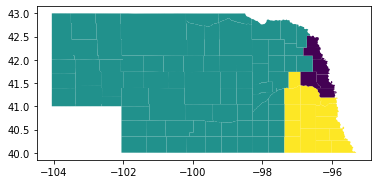

In [15]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()